1. Run "pip install kaggle" 

2. Move "kaggle.json" to following Path /Users/linh/.kaggle

Importing relevent libraries

pip install nbdime

In [4]:
!nbdime config-git --enable

In [1]:
import pandas as pd 
from cleaning import *  # Import all functions from cleaning
import zipfile
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi  # Import Kaggle Api
import requests
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
# Initiliaze API
api = KaggleApi()
api.authenticate()
api.model_list_cli()

# Donwload Dataset via API unzipped
api.dataset_download_files(dataset="alexteboul/heart-disease-health-indicators-dataset", unzip=True)

# Saving DataSets into DF
usa_df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
india_df = pd.read_csv("./Data/CVD_india_data_raw.csv")

In [8]:
india_df.head(5)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [9]:
usa_df.head(5)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Scrape norm tables from Wikipedia

In [8]:
# scraping blood pressure data
url = "https://en.wikipedia.org/wiki/Blood_pressure"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")

categories = []
office_data = []
relevant_data = False

for row in table.find_all('tr'):
    header_cells = row.find_all('th')
    if header_cells and "European Society of Cardiology" in header_cells[0].get_text():
        relevant_data = True
        continue
    if header_cells and "European Society of Hypertension" in header_cells[0].get_text():
        relevant_data = False
        break
    if relevant_data:
        data_cells = row.find_all('td')
        if len(data_cells) > 1:  # Ensures we have enough columns
            categories.append(data_cells[0].get_text(strip=True))
            office_data.append(data_cells[1].get_text(strip=True))

bp_df = pd.DataFrame({'Category': categories, 'Office': office_data})
bp_thresh = int(bp_df[bp_df['Category'] == 'Non-elevated']['Office'].values[0].split("<")[1])

In [9]:
# scraping cholesterol data
url = "https://en.wikipedia.org/wiki/Cholesterol"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")
rows = table.find("tbody").find_all('tr')

chol_data = []
selected_rows = [1, 2, 3, 4]

for i in selected_rows:
    if i == 1:
        cell = rows[i].find('th').get_text(strip=True)
    else:
        cell = rows[i].find('td').get_text(strip=True)
    chol_data.append(cell)

chol_data
chol_thresh = int(chol_data[1].strip("< "))

Creating new binary columns for blood pressure and cholesterol in India data which match the US data

In [11]:
india_df["HighBP"] = india_df["restingBP"].apply(lambda x: 1 if x >= bp_thresh else 0)
# print(india_df["HighBP"].unique())

india_df["HighChol"] = india_df["serumcholestrol"].apply(lambda x: 1 if x >= chol_thresh else 0)
#print(india_df["HighChol"].unique())

Clean and Shaping Data

In [13]:
# apply functions to both datasets for cleaning check
check_nan(india_df)
check_unique(india_df)
print()
check_nan(usa_df)
check_unique(usa_df)

no missings in patientid
no missings in age
no missings in gender
no missings in chestpain
no missings in restingBP
no missings in serumcholestrol
no missings in fastingbloodsugar
no missings in restingrelectro
no missings in maxheartrate
no missings in exerciseangia
no missings in oldpeak
no missings in slope
no missings in noofmajorvessels
no missings in target
no missings in HighBP
no missings in HighChol


# of unique vals in patientid: 1000


# of unique vals in age: 61


# of unique vals in gender: 2
unique vals in gender: [0, 1]


# of unique vals in chestpain: 4
unique vals in chestpain: [0, 1, 2, 3]


# of unique vals in restingBP: 95


# of unique vals in serumcholestrol: 344


# of unique vals in fastingbloodsugar: 2
unique vals in fastingbloodsugar: [0, 1]


# of unique vals in restingrelectro: 3
unique vals in restingrelectro: [0, 1, 2]


# of unique vals in maxheartrate: 129


# of unique vals in exerciseangia: 2
unique vals in exerciseangia: [0, 1]


# of unique vals in 

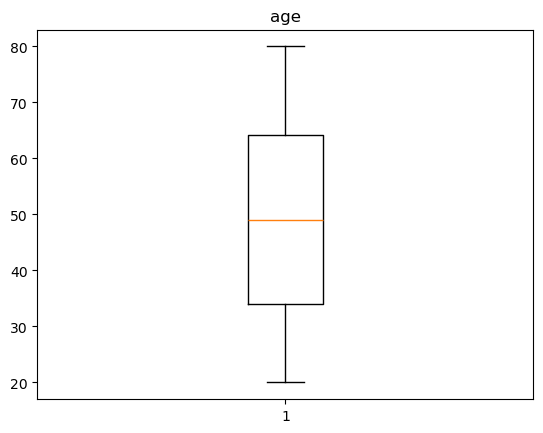

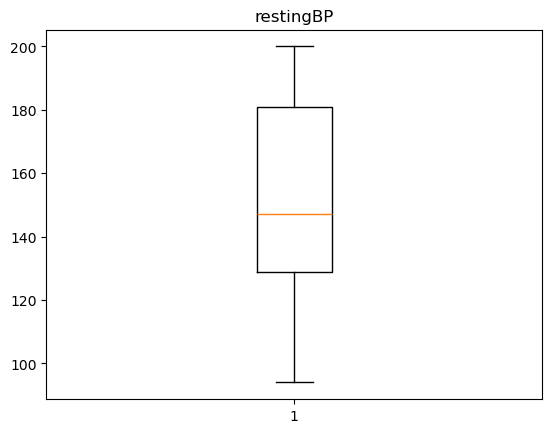

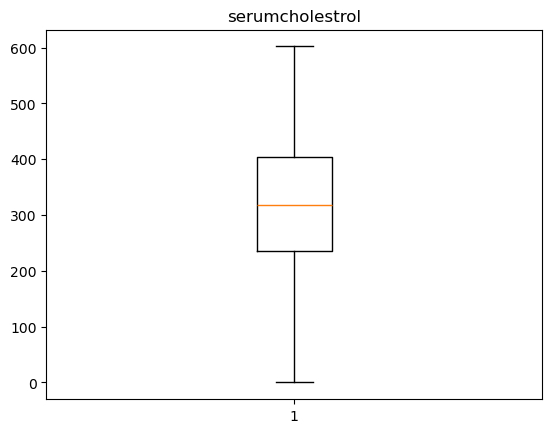

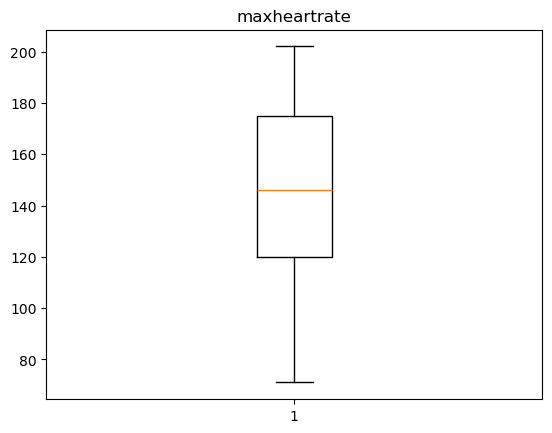

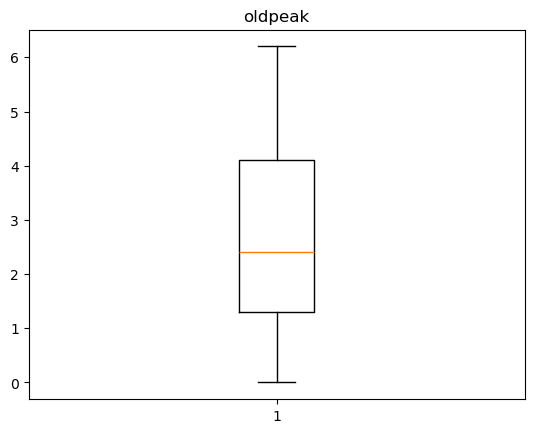

In [14]:
# quantitative cols in india dataset for outlier check
quantitative_cols_india = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak']

for col in quantitative_cols_india:
    plt.figure()
    plt.boxplot(india_df[col].dropna())
    plt.title(f'{col}')
    plt.show()

In [15]:
# Synchronize matching columns
usa_df.columns = usa_df.columns.str.lower()
india_df.columns = india_df.columns.str.lower()

In [16]:
# Aligning Dtypes
usa_df = usa_df.apply(lambda x:x.astype(int))
india_df = india_df.apply(lambda x:x.astype(int, errors= "ignore"))

In [17]:
# Checking and consolidate columns
# Renaming India columns
india_df = india_df.rename(columns={"target":"cvd"})

# Renaming usa columns
usa_df = usa_df.rename(columns={"sex":"gender"})
usa_df = usa_df.rename(columns={"heartdiseaseorattack":"cvd"})

In [18]:
# assgning gender 
# sacrificing performance for readibility in this case int to object
gender = {
    1:"m",
    0:"f"}

india_df["gender"] = india_df["gender"].map(gender)  
usa_df["gender"] = usa_df["gender"].map(gender)

In [19]:
# add country column to both dataframes
india_df['country'] = 'india'
usa_df['country'] = 'usa'

In [20]:
# Concantenate datasets
merged = pd.concat([india_df, usa_df], axis=0, ignore_index=True)
# find common cols
common_columns = india_df.columns.intersection(usa_df.columns)
# drop all columns except those with data in both samples: age, gender, cvd, highbp, highchol
merged = merged[common_columns]
# recode india age to us categories
merged.loc[merged['country'] == 'india', 'age'] = merged.loc[merged['country'] == 'india', 'age'].apply(map_age_to_bin)
# save merged data
merged.to_csv("./Data/merged_data.csv")

Compare demographics (age and gender distribution)

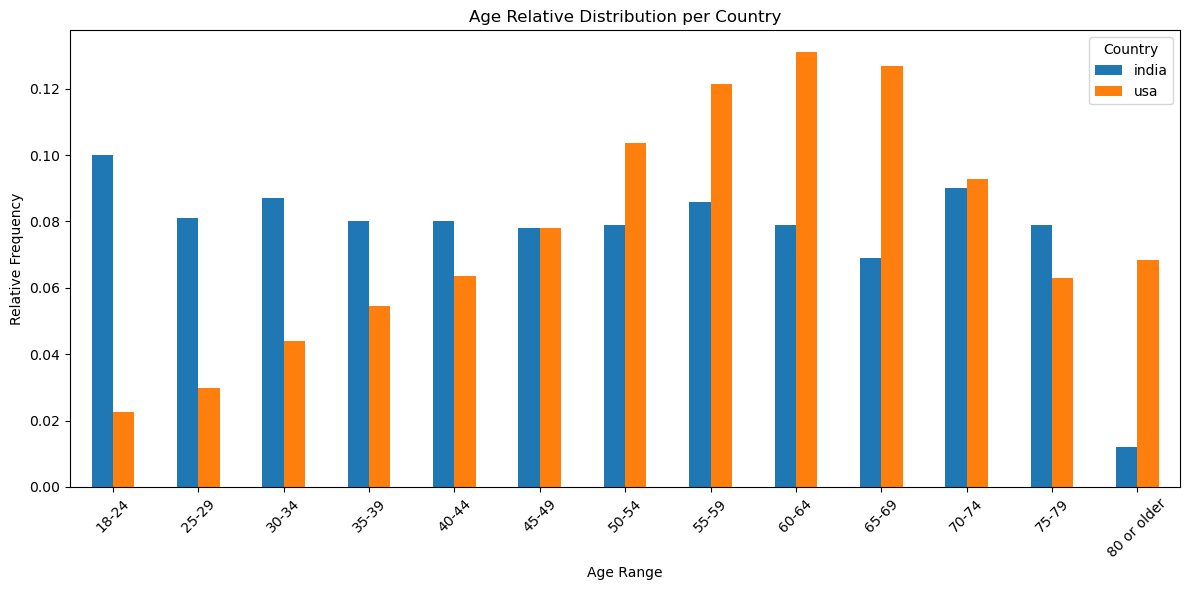

In [22]:
# AGE
# make age category strings (makes labeling easier when plotting)
merged['age_range'] = merged['age'].apply(map_age_to_range)
merged.head()

# calculate relative frequency for each age range per country
age_counts = merged.groupby(['country', 'age_range']).size().reset_index(name='count')
# calculate total count per country for relative frequency calculation
total_counts = age_counts.groupby('country')['count'].sum().reset_index(name='total_count')
# merge total counts back with original counts
age_distribution = age_counts.merge(total_counts, on='country')
# calculate relative frequency
age_distribution['relative_frequency'] = age_distribution['count'] / age_distribution['total_count']
# pivot table for plotting
pivot_table = age_distribution.pivot(index='age_range', columns='country', values='relative_frequency')

# plotting
pivot_table.plot(kind='bar', figsize=(12, 6))
plt.title('Age Relative Distribution per Country')
plt.xlabel('Age Range')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()
plt.show()

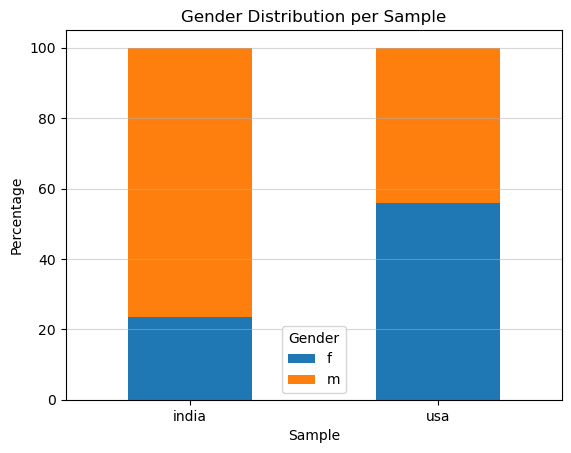

In [23]:
# GENDER
# get gender counts per country
gender_counts = merged.groupby("country")["gender"].value_counts().unstack()
# calculate gender percentage per country
gender_perc = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# plot percentages in stacked bar chart
gender_perc.plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
plt.xlabel('Sample')
plt.title('Gender Distribution per Sample')
plt.xticks(rotation=False)
plt.legend(title='Gender')
plt.grid(axis = "y", alpha = 0.5)
plt.show()

Data Analysis

Analysis on combined data

In [26]:
# H1.1: The prevalence of high blood pressure is higher in the USA compared to India
# H1.2: The prevalence of high cholesterol is higher in the USA compared to India
# H1.3: The prevalence of heart disease is higher in the USA compared to India
grouped = (merged.groupby("country")[["highbp", "highchol", "cvd"]].mean() * 100).round(2)

print("Prevalence by Country:")
print(grouped)
print()

# Logical statements to compare the USA and India for each condition
print("H1.1: The prevalence of high blood pressure is higher in the US compared to India:", grouped.loc["usa", "highbp"] > grouped.loc["india", "highbp"])
print("H1.2: The prevalence of high cholesterol is higher in the US compared to India:", grouped.loc["usa", "highchol"] > grouped.loc["india", "highchol"])
print("H1.3: The prevalence of CVD is higher in the US compared to India:", grouped.loc["usa", "cvd"] > grouped.loc["india", "cvd"])

Prevalence by Country:
         highbp  highchol    cvd
country                         
india      89.4     82.40  58.00
usa        42.9     42.41   9.42

H1.1: The prevalence of high blood pressure is higher in the US compared to India: False
H1.2: The prevalence of high cholesterol is higher in the US compared to India: False
H1.3: The prevalence of CVD is higher in the US compared to India: False


Analysis on US sample

In [28]:
# Additional check: The prevalence of cvd is higher among smokers than non-smokers
smoker = usa_df[usa_df["smoker"] == 1]
non_smoker = usa_df[usa_df["smoker"] == 0]

# Calculating the percentage of individuals with heart disease in each group
cvd_smoker = (smoker["cvd"].mean()) * 100
cvd_non_smoker = (non_smoker["cvd"].mean()) * 100

print(f"CVD prevalence among smokers: {cvd_smoker:.2f}%")
print(f"CVD prevalence among non-smokers: {cvd_non_smoker:.2f}%")
print("The prevalence of CVD is higher among smokers than non-smokers:" , cvd_smoker > cvd_non_smoker)

CVD prevalence among smokers: 13.17%
CVD prevalence among non-smokers: 6.44%
The prevalence of CVD is higher among smokers than non-smokers: True


In [29]:
# Additional check:  The prevalence of cvd is higher among those with high BP
high_bp = usa_df[usa_df["highbp"] == 1]
no_high_bp = usa_df[usa_df["highbp"] == 0]

# Calculating the percentage of individuals with heart disease in each group
heart_disease_high_bp = (high_bp["cvd"].mean()) * 100
heart_disease_no_high_bp = (no_high_bp["cvd"].mean()) * 100

print(f"Percentage with CVD among those with high BP: {heart_disease_high_bp:.2f}%")
print(f"Percentage with CVD among those without high BP: {heart_disease_no_high_bp:.2f}%")
print("The prevalence of CVD is higher among individuals with high BP:" , heart_disease_high_bp > heart_disease_no_high_bp)

Percentage with CVD among those with high BP: 16.47%
Percentage with CVD among those without high BP: 4.12%
The prevalence of CVD is higher among individuals with high BP: True


In [30]:
# Additional check:  The prevalence of cvd is higher among those with high cholesterol
high_chol = usa_df[usa_df["highchol"] == 1]
no_high_chol = usa_df[usa_df["highchol"] == 0]

# Calculating the percentage of individuals with heart disease in each group
heart_disease_high_chol = (high_chol["cvd"].mean()) * 100
heart_disease_no_high_chol = (no_high_chol["cvd"].mean()) * 100

print(f"Percentage with CVD among those with high BP: {heart_disease_high_chol:.2f}%")
print(f"Percentage with CVD among those without high BP: {heart_disease_no_high_chol:.2f}%")
print("The prevalence of CVD is higher among individuals with high cholesterol:" , heart_disease_high_chol > heart_disease_no_high_chol)

Percentage with CVD among those with high BP: 15.57%
Percentage with CVD among those without high BP: 4.89%
The prevalence of CVD is higher among individuals with high cholesterol: True


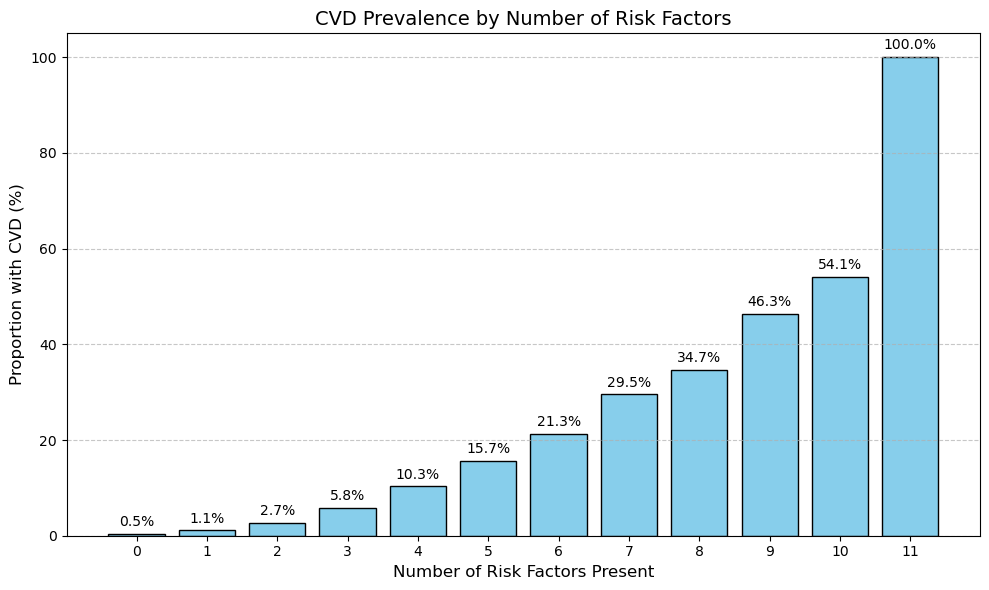

In [31]:
# H4: checking CVD prevalence in groups defined by number of risk factors present
# recode protective factor variables (fruits, veggies, physactivity) to be comparable to risk factors
# replacing 0 with 1 to indicate "not having the protective factor" (thus becoming a risk)
usa_df['fruits'] = usa_df['fruits'].replace({0: 1, 1: 0})
usa_df['veggies'] = usa_df['veggies'].replace({0: 1, 1: 0})
usa_df['physactivity'] = usa_df['physactivity'].replace({0: 1, 1: 0})
usa_df['diabetes'] = usa_df['diabetes'].replace({1: 0, 2: 1}) # make pre-diabetes or borderline diabetes no diabetes

# summing up binary risk factor variables along the horizontal axis to get risk factor count
usa_df['risk_factor_count'] = usa_df[['highbp', 'highchol', 'cholcheck', 'smoker', 'stroke',
                                      'diabetes', 'physactivity', 'fruits', 'veggies', 
                                      'hvyalcoholconsump', 'diffwalk']].sum(axis=1)

# calculate proportion of individuals with CVD for each risk factor count
cvd_prevalence = (usa_df.groupby('risk_factor_count')['cvd'].mean() * 100)

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cvd_prevalence.index, cvd_prevalence, color='skyblue', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')
plt.xlabel('Number of Risk Factors Present', fontsize=12)
plt.ylabel('Proportion with CVD (%)', fontsize=12)
plt.title('CVD Prevalence by Number of Risk Factors', fontsize=14)
plt.xticks(ticks=range(usa_df['risk_factor_count'].min(), usa_df['risk_factor_count'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Mean CVD prevalence in lower income groups (<$10k-$25k): 16.07%
Mean CVD prevalence in higher income groups ($35k-$75k+): 7.65%


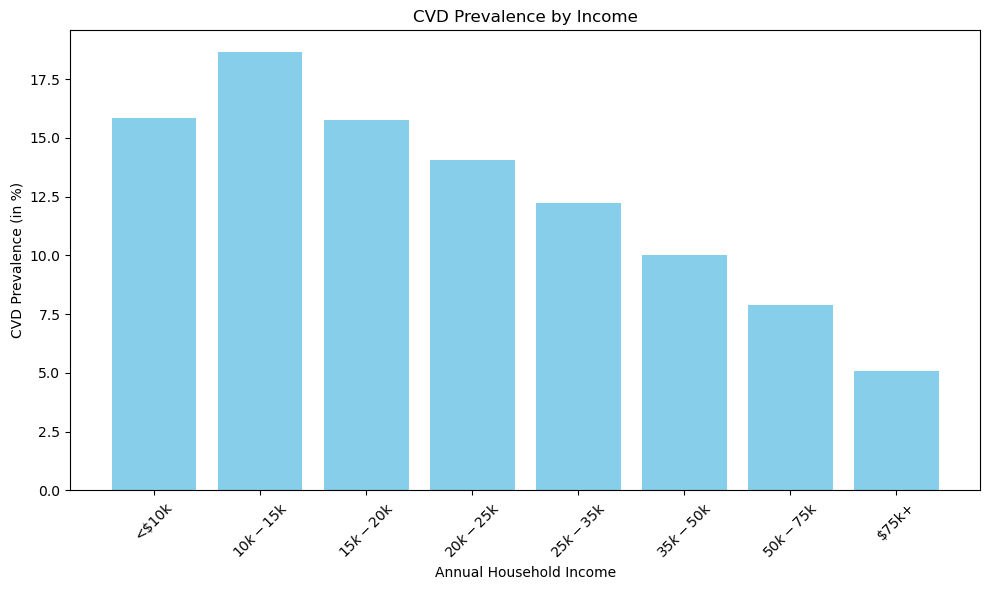

In [32]:
# H5: The prevalence of cvd is higher among those with lower compared to higher income
income_us = usa_df.groupby('income')
cvd_count = income_us['cvd'].sum()
cvd_total = income_us['cvd'].count()
cvd_prev_income = (cvd_count / cvd_total)*100

# series to df
cvd_prev_income = cvd_prev_income.reset_index()

# rename cols
cvd_prev_income.columns = ['income', 'cvd_prevalence']

# Apply the mapping function to replace the income values
cvd_prev_income['income'] = cvd_prev_income['income'].apply(map_amount_to_cat)

# test hypothesis numerically
lower_income = cvd_prev_income[cvd_prev_income['income'].isin(['<$10k', '$10k-$15k', '$15k-$20k', '$20k-$25k'])]['cvd_prevalence'].mean()
higher_income = cvd_prev_income[cvd_prev_income['income'].isin(['$35k-$50k', '$50k-$75k', '$75k+'])]['cvd_prevalence'].mean()

print(f"Mean CVD prevalence in lower income groups (<$10k-$25k): {lower_income:.2f}%")
print(f"Mean CVD prevalence in higher income groups ($35k-$75k+): {higher_income:.2f}%")

#plotting all income groups
plt.figure(figsize=(10, 6))
plt.bar(cvd_prev_income['income'], cvd_prev_income['cvd_prevalence'], color='skyblue')
plt.xlabel('Annual Household Income')
plt.ylabel('CVD Prevalence (in %)')
plt.title('CVD Prevalence by Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

High Chol > in CVD than no CVD

Zusammenhänge 
RestingBP + Serumcholesterol + Max Heartrate + Age

HighBP + HighCholestoral + CVD # wie in USA

Boxplot 




In [37]:
# Getting an overview for categorical values

india_grouped_1 = india_df.groupby("cvd")[["highbp","highchol"]].sum()
india_grouped_1

,highbp,highchol
cvd,,
0,334,340
1,560,484


In [38]:
india_grouped_1= india_grouped_1.reset_index()

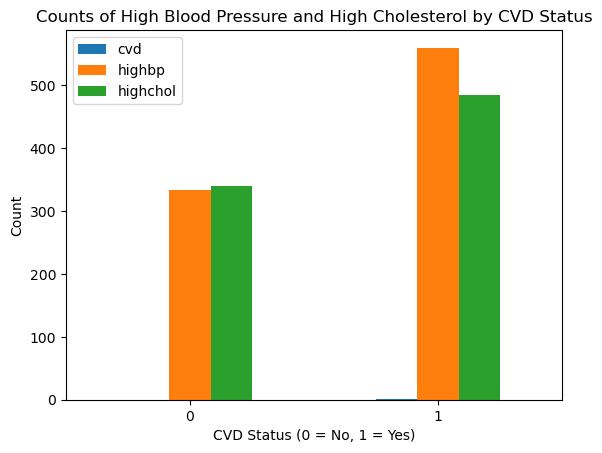

In [39]:
# Assuming india_grouped_1 is the summarized DataFrame showed
# Plotting the data using the existing table format
india_grouped_1.plot(kind="bar")
plt.title('Counts of High Blood Pressure and High Cholesterol by CVD Status')
plt.ylabel('Count')
plt.xlabel('CVD Status (0 = No, 1 = Yes)')
plt.xticks(rotation=0)
plt.show()

Now getting an overview for the numerical Values:

         restingbp  serumcholestrol  maxheartrate         age
count  1000.000000      1000.000000   1000.000000  1000.00000
mean    151.747000       311.447000    145.477000    49.24200
std      29.965228       132.443801     34.190268    17.86473
min      94.000000         0.000000     71.000000    20.00000
25%     129.000000       235.750000    119.750000    34.00000
50%     147.000000       318.000000    146.000000    49.00000
75%     181.000000       404.250000    175.000000    64.25000
max     200.000000       602.000000    202.000000    80.00000


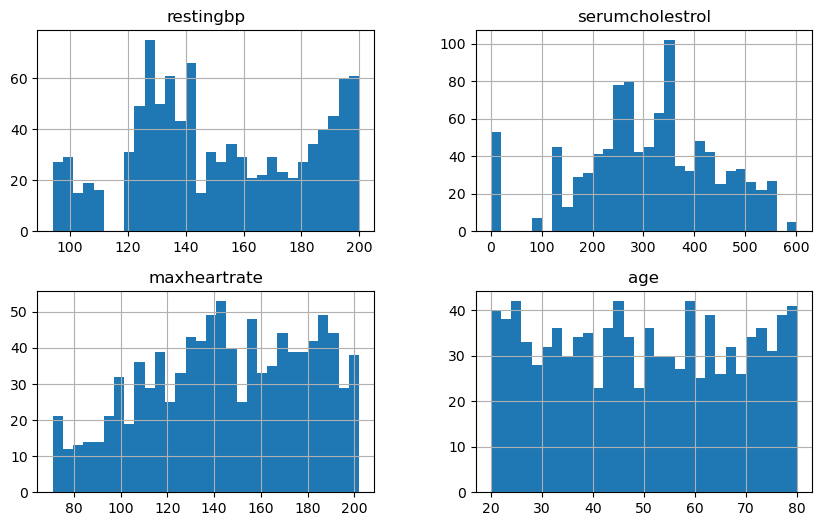

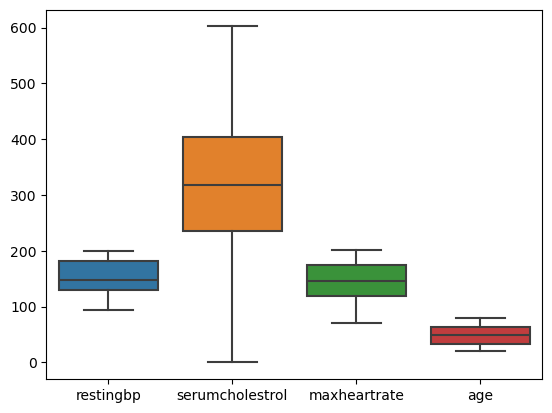

In [41]:
# Summary statistics for continuous variables
print(india_df[['restingbp', 'serumcholestrol', 'maxheartrate', 'age']].describe())

# Plot histograms for each variable
india_df[['restingbp', 'serumcholestrol', 'maxheartrate', 'age']].hist(bins=30, figsize=(10, 6))
plt.show()

# Boxplots to identify outliers
sb.boxplot(data=india_df[['restingbp', 'serumcholestrol', 'maxheartrate', 'age']])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

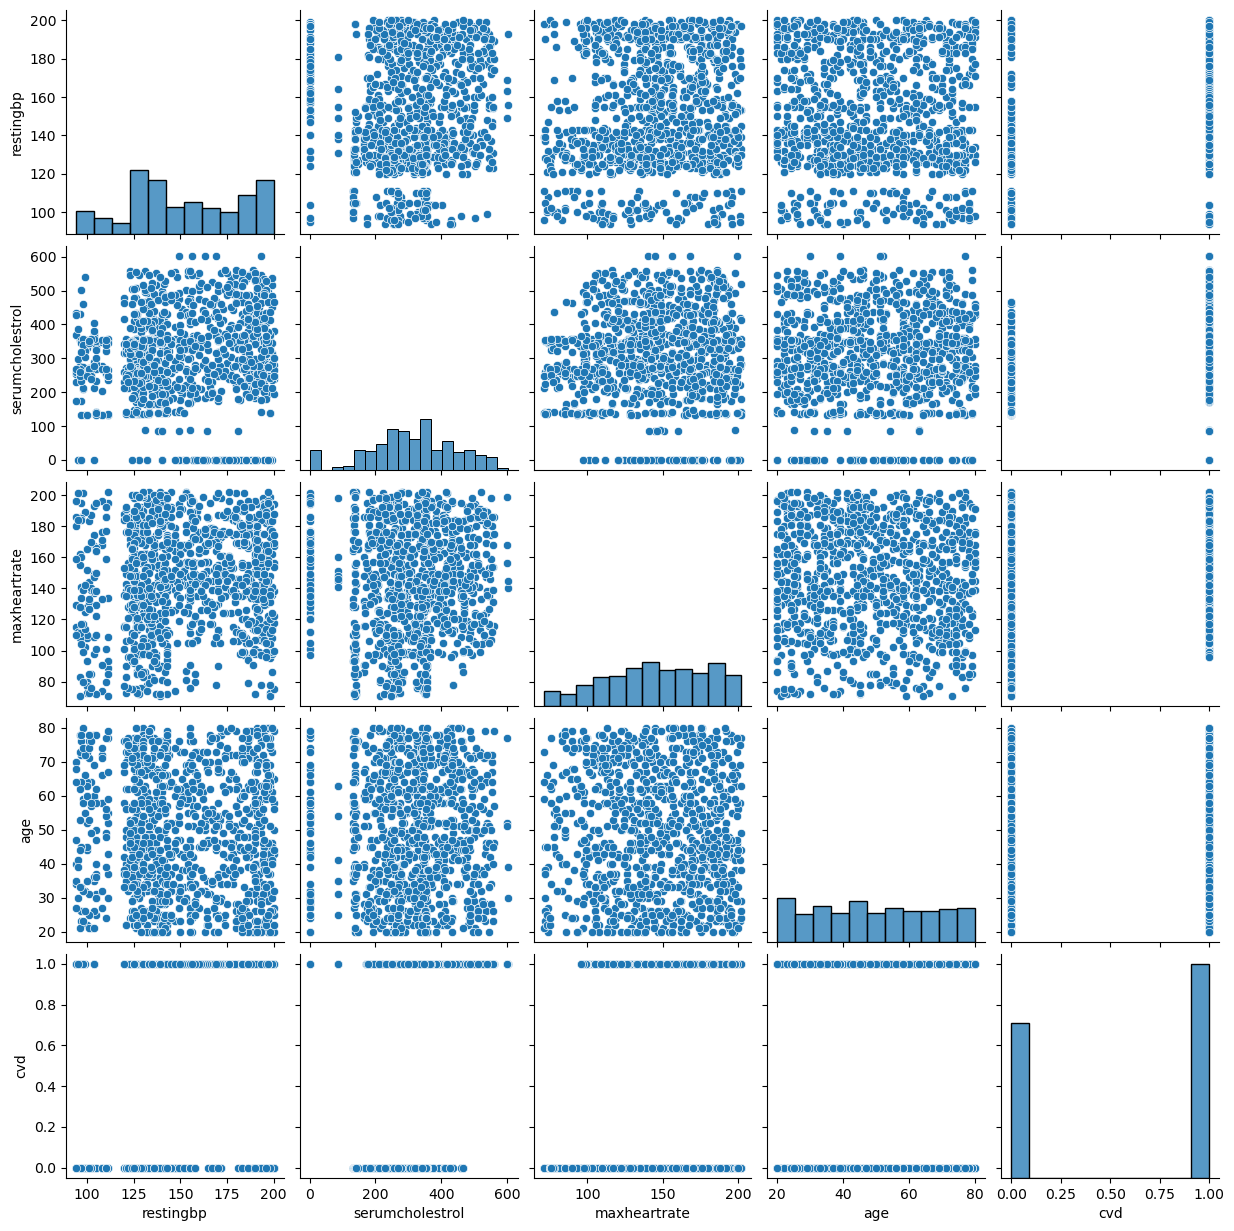

In [42]:
# Scatterplots for each pair of variables
sb.pairplot(india_df[["restingbp", "serumcholestrol","maxheartrate", "age","cvd"]])
plt.show()

Since the pairs a distributed everywhere, there is no direct correlation between the 4 variables recognizable

also there is no clear correlation distributed to "cvd"

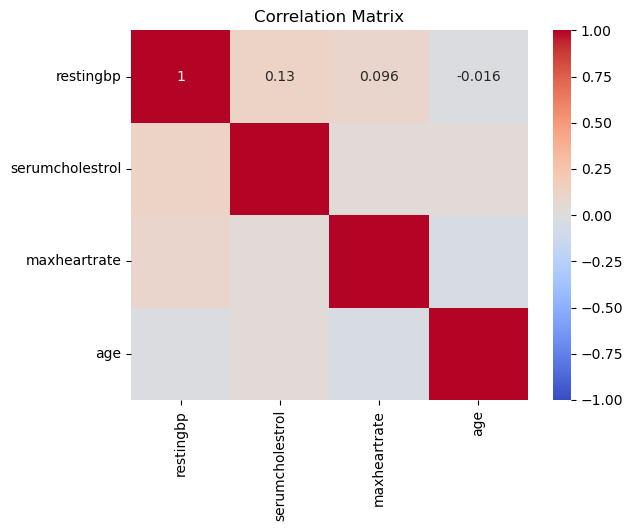

In [44]:
# Now Checking with a correlation Matrix


# Create a correlation matrix
corr_matrix = india_df[['restingbp', 'serumcholestrol', 'maxheartrate', 'age']].corr()

# Plot the correlation matrix as a heatmap
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


There seems to be a light positive correlation between restingbp and cvd.

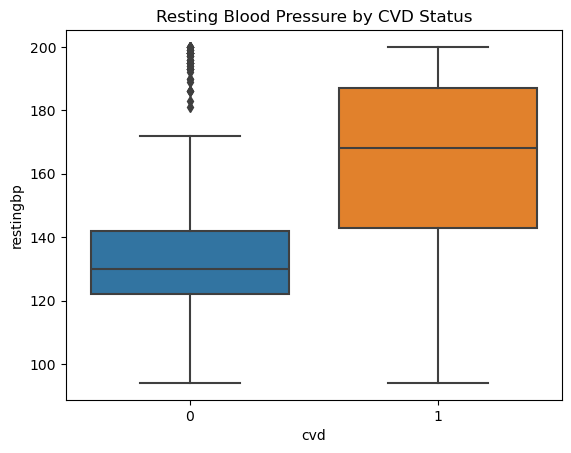

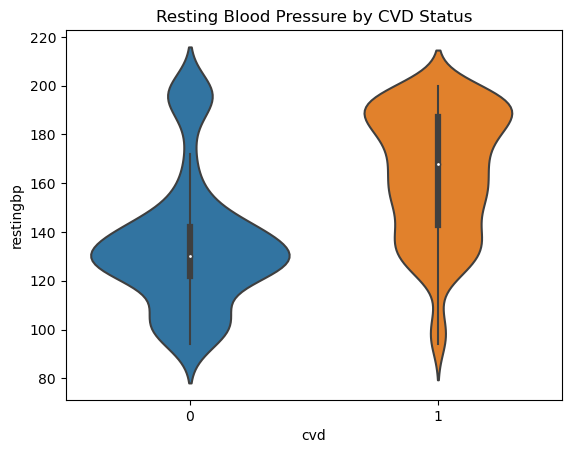

In [46]:
# Resting blood pressure distribution by CVD status
sb.boxplot(x='cvd', y='restingbp', data=india_df)
plt.title('Resting Blood Pressure by CVD Status')
plt.show()

# Resting blood pressure distribution by CVD status
sb.violinplot(x='cvd', y='restingbp', data=india_df)
plt.title('Resting Blood Pressure by CVD Status')
plt.show()

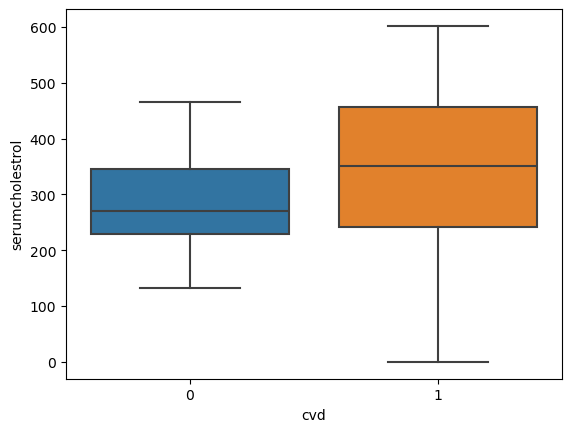

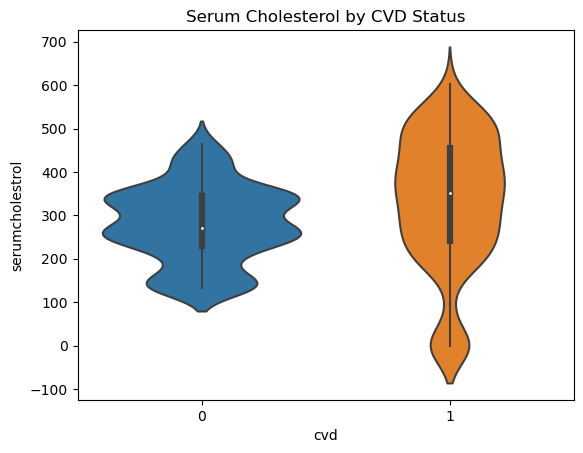

In [47]:
# Boxplot
sb.boxplot(x="cvd",y="serumcholestrol",data=india_df)
plt.show()

# Serum cholesterol distribution by CVD status
sb.violinplot(x='cvd', y='serumcholestrol', data=india_df)
plt.title('Serum Cholesterol by CVD Status')
plt.show()

Since the plots show a clear higher median and a wider distribution of higher cholesterol values in individuals with CVD, this supports the hypothesis that higher cholesterol levels are correlated with an increased likelihood of having CVD.


Conclusion: With Correlation Matrix
The hypothesis "Higher cholesterol levels correlate with a higher likelihood of CVD" is still valid, even with a correlation of 0.2. The weak correlation suggests that cholesterol is one contributing factor but is not the sole determinant of CVD risk. You could explore how other factors (like age, BMI, or blood pressure) combine with cholesterol to better explain the likelihood of having CVD.

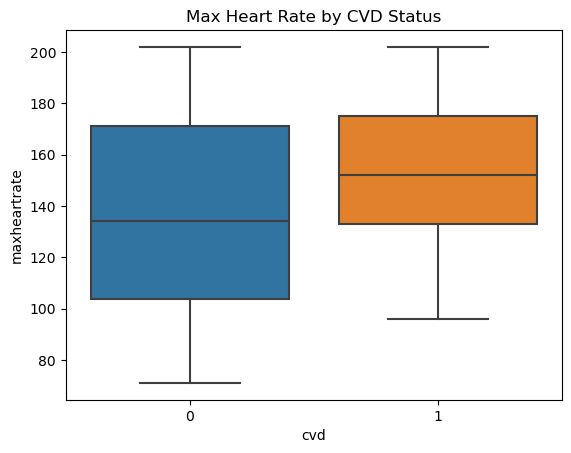

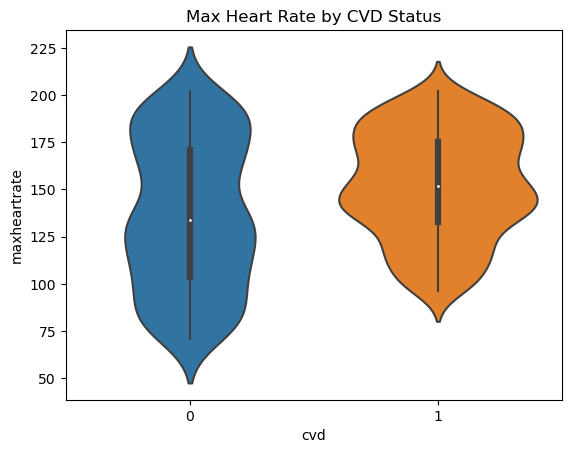

In [49]:
# Max heart rate distribution by CVD status
sb.boxplot(x='cvd', y='maxheartrate', data=india_df)
plt.title('Max Heart Rate by CVD Status')
plt.show()

# Max heart rate distribution by CVD status
sb.violinplot(x='cvd', y='maxheartrate', data=india_df)
plt.title('Max Heart Rate by CVD Status')
plt.show()

Conclusion with Correlation Matrix

correlation matrix shows a correlation coefficient of 0.23 between max heart rate and CVD:
This weak positive correlation suggests that individuals with higher max heart rates may be less likely to have CVD, reinforcing the idea that max heart rate could be an indicator of cardiovascular health.
While there is some relationship, the weak correlation indicates that other factors also play a role in determining CVD risk.

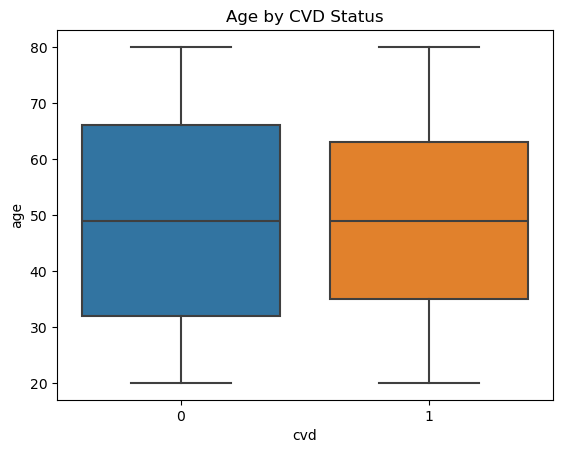

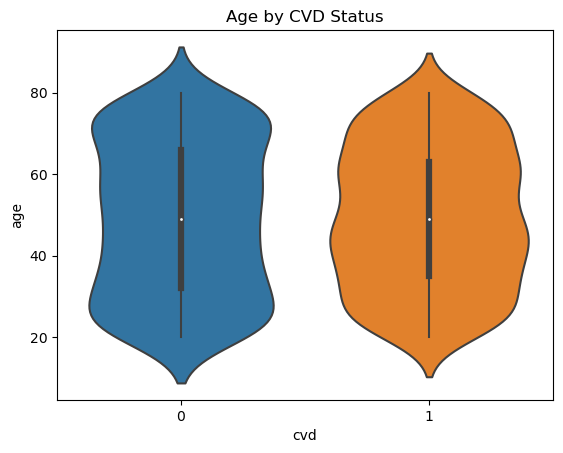

In [52]:
# Age distribution by CVD status
sb.boxplot(x='cvd', y='age', data=india_df)
plt.title('Age by CVD Status')
plt.show()

# Age distribution by CVD status
sb.violinplot(x='cvd', y='age', data=india_df)
plt.title('Age by CVD Status')
plt.show()

Conclusion with Correlation Matrix

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

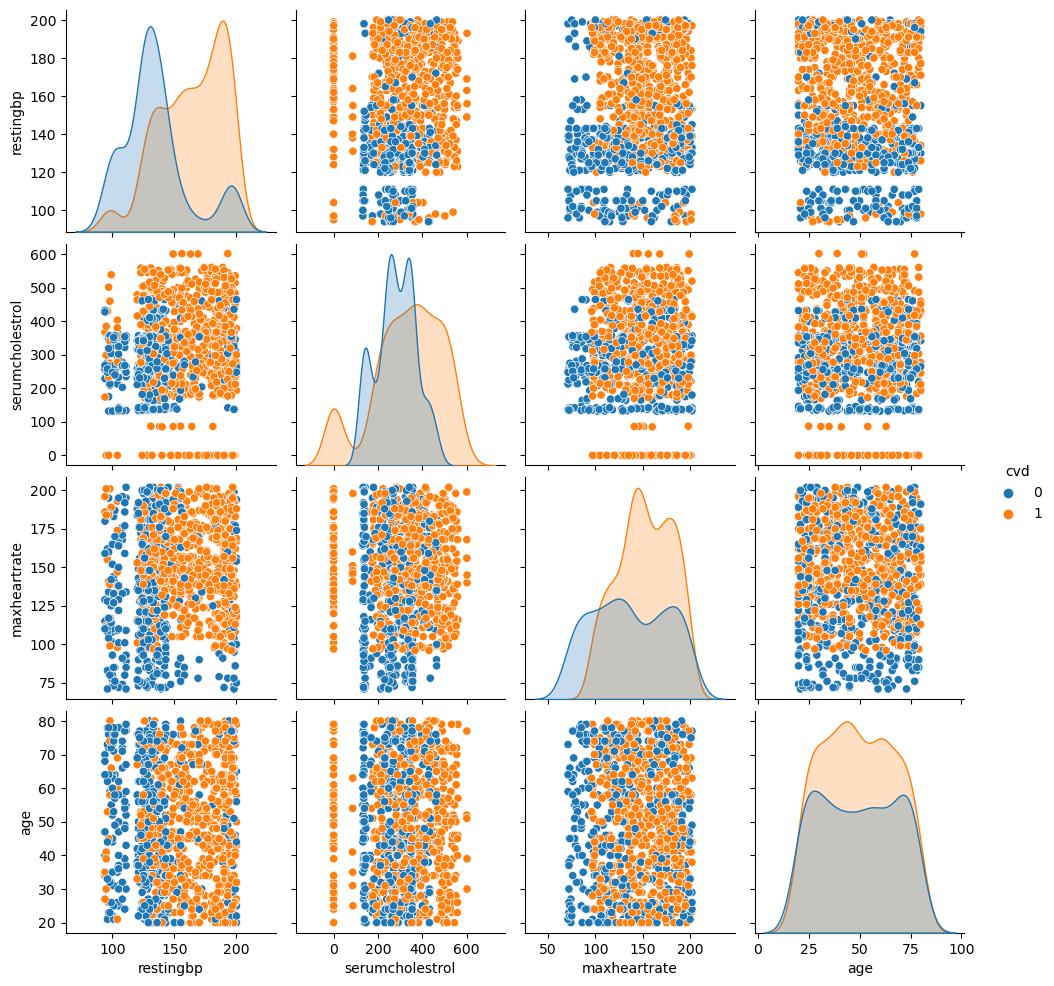

In [54]:
# Scatterplots for each pair of variables
# Together with "CVD" Yes or no Correlation
sb.pairplot(india_df[["restingbp", "serumcholestrol","maxheartrate", "age","cvd"]], hue="cvd")
plt.show()